# How Neural Networks Learn Physics: Predicting Trajectories

We want to train a neural network to learn the behavior of projectile motion (like cannonball flights), without giving it any physics equations — just by observing data:  
👉 *Launch speed, angle → Landing coordinates or trajectory*

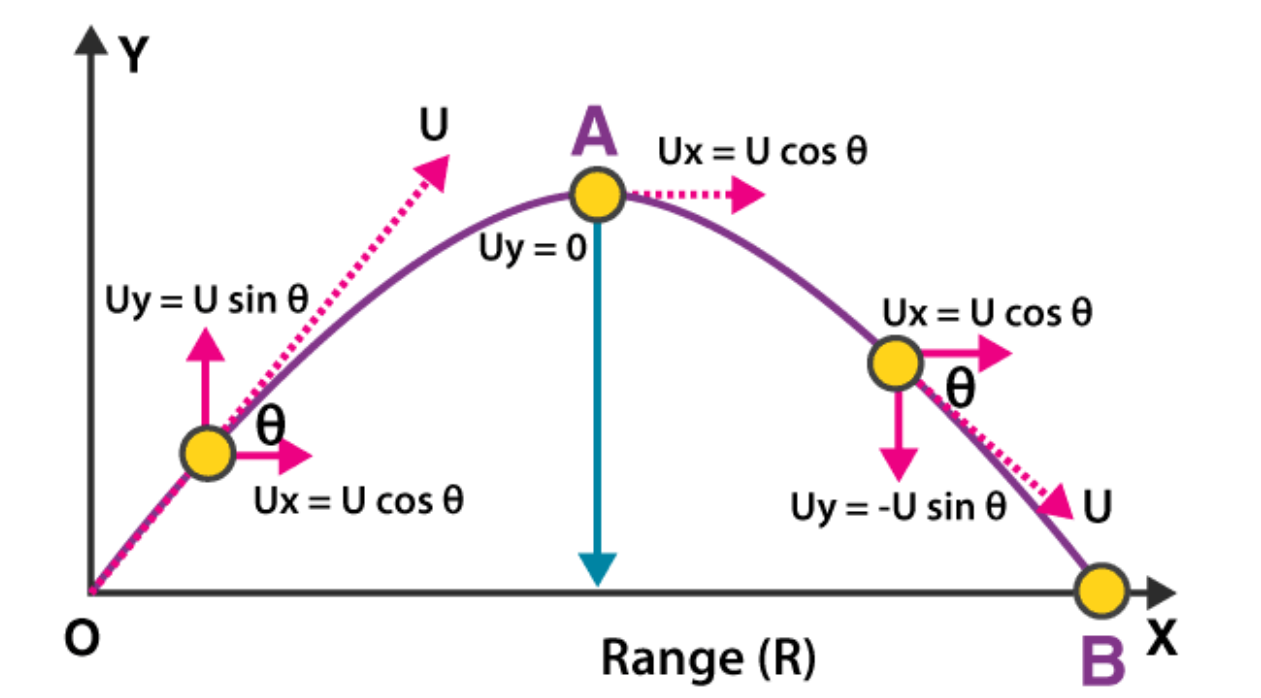


# Step 1: Use physics to generate synthetic data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

g = 9.81  # gravity

# Generate dataset
def generate_projectile_data(num_samples=10000):
    X = []  # features: [speed, angle]
    Y = []  # target: [x_final, y_max]
    
    for _ in range(num_samples):
        speed = np.random.uniform(10, 100)  # m/s
        angle_deg = np.random.uniform(10, 80)  # degrees
        angle_rad = np.radians(angle_deg)
        
        # Physics equations
        vx = speed * np.cos(angle_rad)  
        vy = speed * np.sin(angle_rad)
        
        time_of_flight = 2 * vy / g
        x_final = vx * time_of_flight
        y_max = (vy**2) / (2 * g)
        
        X.append([speed, angle_deg])
        Y.append([x_final, y_max])
    
    return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)

X, Y = generate_projectile_data()

print("Few Samples of [speed, angle]: \n", X[:5])
print("Few Samples of [x_final, y_max]: \n", Y[:5])

Few Samples of [speed, angle]: 
 [[84.87786  47.68625 ]
 [54.418552 12.113874]
 [71.19331  55.3448  ]
 [30.063173 62.242897]
 [70.57658  18.686632]]
Few Samples of [x_final, y_max]: 
 [[731.1522    200.78462  ]
 [123.878235    6.6471424]
 [483.34473   174.80147  ]
 [ 75.939606   36.07351  ]
 [308.20844    26.060665 ]]


# Step 2: Train Neural Network in PyTorch

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X)
Y_tensor = torch.tensor(Y)

# Create DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define a simple feedforward neural network
class TrajectoryNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 2)  # Outputs: [x_final, y_max]
        )

    def forward(self, x):
        return self.net(x)

model = TrajectoryNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Step 3: Train the Model

In [3]:
# Training loop
for epoch in range(200):
    for batch_X, batch_Y in loader:
        pred = model(batch_X)
        loss = criterion(pred, batch_Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 20 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 13076.0762
Epoch 20, Loss: 1398.0432
Epoch 40, Loss: 427.3854
Epoch 60, Loss: 73.3473
Epoch 80, Loss: 62.0618
Epoch 100, Loss: 32.4789
Epoch 120, Loss: 33.6014
Epoch 140, Loss: 26.9092
Epoch 160, Loss: 7.7292
Epoch 180, Loss: 11.5613


# Step 4: Test & Compare with Real Physics

In [4]:
# Test on new sample
test_speed = 60
test_angle = 45
test_input = torch.tensor([[test_speed, test_angle]], dtype=torch.float32)

predicted = model(test_input).detach().numpy()[0]

# Ground truth from physics
angle_rad = np.radians(test_angle)
vx = test_speed * np.cos(angle_rad)
vy = test_speed * np.sin(angle_rad)
t_flight = 2 * vy / g
x_actual = vx * t_flight
y_actual = vy**2 / (2 * g)

print("Predicted:", predicted)
print("Actual:   ", [x_actual, y_actual])


Predicted: [375.1947   91.85675]
Actual:    [np.float64(366.9724770642202), np.float64(91.74311926605505)]


# Step 5: Visualize the match with Actual vs AI

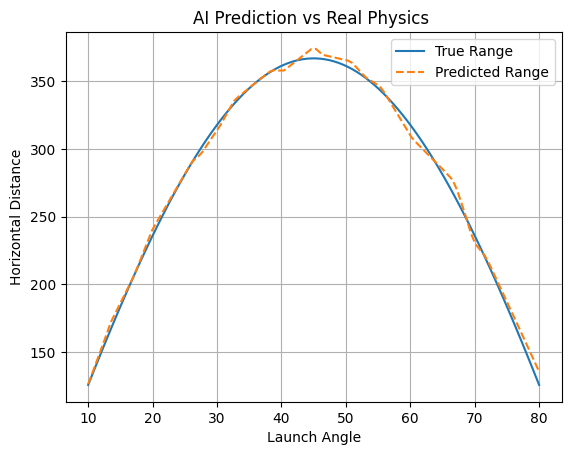

In [6]:
# Multiple test angles
angles = np.linspace(10, 80, 100)
true_vals = []
pred_vals = []

for angle in angles:
    test_input = torch.tensor([[60, angle]], dtype=torch.float32)
    pred = model(test_input).detach().numpy()[0]
    pred_vals.append(pred)

    rad = np.radians(angle)
    vx = 60 * np.cos(rad)
    vy = 60 * np.sin(rad)
    x_actual = vx * (2 * vy / g)
    y_actual = vy**2 / (2 * g)
    true_vals.append([x_actual, y_actual])

true_vals = np.array(true_vals)
pred_vals = np.array(pred_vals)

plt.plot(angles, true_vals[:, 0], label='True Range')
plt.plot(angles, pred_vals[:, 0], '--', label='Predicted Range')
plt.legend()
plt.xlabel("Launch Angle")
plt.ylabel("Horizontal Distance")
plt.title("AI Prediction vs Real Physics ")
plt.grid(True)
plt.savefig('ai-vs-physics.png')
plt.show()